In [1]:
from IPython.display import Image

# 3.1 소개

# 3.2 오토인코더

![nn](Image/1.jpg)

### 3.2.1 패션 MNIST 데이터셋

오토인코더를 구축하고 실제 데이터셋에 적용

패션 MNIST 데이터셋은 의류 이미지를 포함하며, 각 이미지는 28x28 픽셀 크기를 가짐. 
이 데이터를 32x32 픽셀로 패딩하여 사용.
![nn](Image/3-3.png)

In [2]:
##########################
##### IMPORT LIBRARY #####
##########################
import numpy as np # numpy 라이브러리 임포트

import torch # pytorch 라이브러리 임포트 
from torch import nn  # 신경망 모듈을 위한 nn 임포트
from torch.nn import functional as F
from torch.utils.data import DataLoader # 데이터 로딩을 위한 DataLoader 임포트

import torchvision # 컴퓨터 비전 관련 라이브러리 torchvision 임포트
import torchvision.transforms as Transforms # 이미지 변환을 위한 Transforms 임포트
from torchsummary import summary    # 모델 요약 출력을 위한 summary 임포트

from matplotlib import pyplot as plt

#############################
##### 0.TRAIN PARMETERS #####
#############################
IMAGE_SIZE = 32    # 이미지 크기 설정
CHANNELS = 1       # 채널 수 설정 (흑백 이미지이므로 1)
BATCH_SIZE = 128
EMBEDDING_DIM = 2   # 잠재공간의 차원 수 설정 (2D 벡터) : latents
EPOCHS = 10
LEARNING_RATE = 1e-3

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(DEVICE)

########################
##### 1.DATALOADER #####
########################
def get_dataloaders():

    # first define a transform function, to turn images into tersors
    transform = Transforms.Compose([
                    Transforms.ToTensor(),   # 이미지를 Tensor로 변환
                    Transforms.Pad(2)])      # 이미지 가장자리에 패딩 추가 28x28->32x32
    
    # load MNIST dataset
    train_ds = torchvision.datasets.FashionMNIST(root='./data', train=True,
                                          download=True, transform=transform) # 학습 데이터셋 로드
    test_ds = torchvision.datasets.FashionMNIST(root='./data', train=False,
                                         download=True, transform=transform)  # 테스트 데이터셋 로드
    train_loader = DataLoader(dataset=train_ds, batch_size=BATCH_SIZE,
                              shuffle=True, num_workers=4)  # 학습 데이터 로더 생성
    test_loader = DataLoader(dataset=test_ds, batch_size=BATCH_SIZE,
                              shuffle=False, num_workers=4)  # 테스트 데이터 로더 생성
    return train_loader, test_loader

train_loader, test_loader = get_dataloaders()  # 데이터 로더 가져오기
print(next(iter(train_loader))[0].shape)   # 첫 번째 배치의 이미지 크기 출력

cuda


100%|███████████████████████████████████████████████████████████████████████████████| 26421880/26421880 [00:39<00:00, 671208.32it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|█████████████████████████████████████████████████████████████████████████████████████| 29515/29515 [00:00<00:00, 113488.33it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|█████████████████████████████████████████████████████████████████████████████████| 4422102/4422102 [00:13<00:00, 325536.83it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|█████████████████████████████████████████████████████████████████████████████████████| 5148/5148 [00:00<00:00, 13238673.81it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



torch.Size([128, 1, 32, 32])


### 3.2.2 오토인코더 구조

오토인코더는 인코더와 디코더로 구성. 인코더는 입력 이미지를 압축하여 잠재 공간 표현을 생성하고, 디코더는 이 잠재 공간 표현을 다시 원본 이미지로 복원.
![nn](Image/3-4.png)

### 3.2.3 인코더

![nn](Image/2.jpg)

### conv2d: 32 ---> 16

![nn](Image/eq.png)

![nn](Image/eq2.png)

k: kemel size, p: padding, s: stride

stride: 필터가 한 번에 입력 위를 이동하는 크기
/ padding: 입력 데이터 가장자리에 0을 (제로 패딩) 추가되는 픽셀

### convT2d: 16 ---> 32

![nn](Image/eq3.png)

![nn](Image/eq4.png)



인코더는 여러 층의 합성곱 레이어와 ReLU 활성화 함수로 구성되며, 최종적으로 잠재 공간 벡터를 생성합니다.

In [3]:
###################################
##### 2.Build the Autoencoder #####
###################################

# Encoder
class Encoder(nn.Module):  # 인코더 클래스 정의
    def __init__(self, latents):   # 클래스 초기화
        super().__init__()    # nn.Module 초기화
        self.latents = latents  # 잠재 공간 크기 설정
        self.model = nn.Sequential(   # 순차적 모델 정의
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=2, padding=1), # 첫 번째 합성곱 레이어
            nn.ReLU(),  # activation f
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1),  # 두 번째 합성곱 레이어
            nn.ReLU(),   # activation f
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1),  # 세 번째 합성곱 레이어
            nn.ReLU(),  # activation f
            nn.Flatten(),   # 평탄화
            nn.Linear(in_features=2048, out_features=self.latents)   # fully connected layer
        )

    def forward(self, x):  # 순전파 함수 정의
        return self.model(x)  # 입력 x를 모델에 전달하여 출력 반환

# encoder = Encoder(EMBEDDING_DIM).to(DEVICE)
# summary(encoder, (1, 32, 32))

### 3.2.4 디코더

디코더는 인코더의 역순으로, 잠재 공간 벡터를 입력받아 원본 이미지를 복원하는 역할을 합니다.

In [4]:
# Decoder
class Decoder(nn.Module):   # 디코더 클래스 정의
    def __init__(self, latents):  # 클래스 초기화
        super().__init__()  # nn.Module 초기화
        self.latents = latents  # 잠재 공간 크기 설정
        self.fc = nn.Linear(self.latents, 2048) # fully connected layer

        self.model = nn.Sequential(  # 순차적 모델 정의
            nn.ConvTranspose2d(in_channels=128, out_channels=128, 
                               kernel_size=3, stride=2, padding=1, output_padding=1),  # 첫 번째 전치 합성곱 레이어
            nn.ReLU(),  # activation f
            nn.ConvTranspose2d(in_channels=128, out_channels=64, 
                               kernel_size=3, stride=2, padding=1, output_padding=1),  # 두 번째 전치 합성곱 레이어
            nn.ReLU(),  # activation f
            nn.ConvTranspose2d(in_channels=64, out_channels=32, 
                   kernel_size=3, stride=2, padding=1, output_padding=1),  # 세 번째 전치 합성곱 레이어
            nn.ReLU(),  # activation f
            nn.Conv2d(in_channels=32, out_channels=1, kernel_size=3, stride=1, padding=1)  # 출력 합성곱 레이어
        )

    def forward(self, x):  # 순전파 함수 정의
        x = self.fc(x)  # fully connected layer 통과
        x = x.reshape(x.shape[0], 128, 4, 4)  # 텐서 형태 재조정
        x = self.model(x)  # 모델에 입력 x 전달하여 출력 반환
        return x  # 최종 출력 반환

# decoder = Decoder(EMBEDDING_DIM).to(DEVICE)
# summary(decoder, (EMBEDDING_DIM,))

### 3.2.5 인코더와 디코더 연결하기

인코더와 디코더를 연결하여 오토인코더 모델을 구성합니다.

In [5]:
# AutoEncoder
class AE(nn.Module):  # 오토인코더 클래스 정의
    def __init__(self, latents):  # 클래스 초기화
        super().__init__()  # nn.Module 초기화
        self.encoder = Encoder(latents)  # 인코더 초기화
        self.decoder = Decoder(latents)  # 디코더 초기화

    def forward(self, x):  # 순전파 함수 정의
        z = self.encoder(x)  # 입력 x를 인코더에 전달하여 잠재 공간 벡터 z 생성
        recon_x = self.decoder(z)  # 잠재 공간 벡터 z를 디코더에 전달하여 복원 이미지 recon_x 생성      
        return recon_x  # 복원 이미지 반환

    def generate(self, z):  # 새로운 이미지 생성 함수
        return F.sigmoid(self.decoder(z))  # 디코더를 사용하여 z로부터 이미지를 생성하고 시그모이드 함수 적용  (0과 1 사이)

ae = AE(EMBEDDING_DIM).to(DEVICE)  # 오토인코더 모델 생성 및 GPU로 이동
summary(ae, (1, 32, 32))    # 모델 요약 출력 (채널수, 이미지 높이, 이미지 너비): 32x32 픽셀 크기의 단일채널(흑백) 이미지

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 16, 16]             320
              ReLU-2           [-1, 32, 16, 16]               0
            Conv2d-3             [-1, 64, 8, 8]          18,496
              ReLU-4             [-1, 64, 8, 8]               0
            Conv2d-5            [-1, 128, 4, 4]          73,856
              ReLU-6            [-1, 128, 4, 4]               0
           Flatten-7                 [-1, 2048]               0
            Linear-8                    [-1, 2]           4,098
           Encoder-9                    [-1, 2]               0
           Linear-10                 [-1, 2048]           6,144
  ConvTranspose2d-11            [-1, 128, 8, 8]         147,584
             ReLU-12            [-1, 128, 8, 8]               0
  ConvTranspose2d-13           [-1, 64, 16, 16]          73,792
             ReLU-14           [-1, 64,

### 3.2.6 이미지 재구성하기

모델을 훈련하고, 손실 함수를 통해 모델 성능을 평가합니다.

In [6]:
#########################################################
##### 3. Define the model, objective, and optimizer #####
#########################################################

ae = AE(EMBEDDING_DIM).to(DEVICE)  # 오토인코더 모델 생성 및 GPU로 이동

if torch.__version__.split('.')[0] == '2':  # 훈련 함수 정의
    torch.set_float32_matmul_precision('high')
    ae = torch.compile(ae) # PyTorch 2.0 feature
    print('model compiled')

loss_fn = nn.BCEWithLogitsLoss(reduction='mean')   # 손실 함수 정의
optim = torch.optim.Adam(ae.parameters(), lr=LEARNING_RATE)  # Adam 옵티마이저 정의

##############################
##### 4. Get dataloaders #####
##############################

train_loader, test_loader = get_dataloaders()

###################################################
#####5. Define train and validation functions #####
###################################################
# A single epoch train funcion
def train(model, dataloader, optimizer, loss_fn):  # 훈련 함수 정의

    model.train()  # 모델을 훈련 모드로 전환
    train_loss = 0  # 훈련 손실 초기화

    for i, (train_x, train_y) in enumerate(dataloader):  # 데이터 로더를 사용하여 배치 단위로 데이터 로드
        optimizer.zero_grad()  # 옵티마이저의 기울기 초기화
        train_x = train_x.to(DEVICE)  # 입력 데이터를 GPU로 이동
        recon_x = model(train_x)  # 입력 데이터를 모델에 전달하여 복원 이미지 생성  <--forward
        loss = loss_fn(recon_x, train_x)  # 원본 이미지와 복원 이미지 간의 손실 계산

        loss.backward()  # 역전파를 통해 기울기 계산
        optimizer.step()  # 옵티마이저를 사용하여 모델 파라미터 업데이트

        train_loss += loss.item()  # 배치 손실을 누적

    return train_loss / len(dataloader)  # 평균 훈련 손실 반환

# Validation function
def validate(model, dataloader, loss_fn):  # 검증 함수 정의
    
    model.eval()  # 모델을 평가 모드로 전환
    test_loss = 0  # 테스트 손실 초기화
    for i, (test_x, test_y) in enumerate(dataloader):  # 데이터 로더를 사용하여 배치 단위로 데이터 로드
        test_x = test_x.to(DEVICE)  # 입력 데이터를 GPU로 이동
        with torch.no_grad():  # 기울기 계산 비활성화
            recon_x = model(test_x)  # 입력 데이터를 모델에 전달하여 복원 이미지 생성
            loss = loss_fn(recon_x, test_x)  # 원본 이미지와 복원 이미지 간의 손실 계산

        test_loss += loss # 배치 손실을 누적
    return test_loss / len(dataloader)  # 평균 테스트 손실 반환

#################################
##### 6. Train and evaluate #####
#################################

for i in range(EPOCHS):  # 지정된 에포크 수만큼 훈련 반복
    train_loss = train(ae, train_loader, optim, loss_fn)  # 훈련 함수 호출
    test_loss = validate(ae, test_loader, loss_fn)  # 검증 함수 호출

    print(f'Epoch {i + 1}')  # 현재 에포크 번호 출력
    print(f'\tTrain - loss: {train_loss:.4f}')  # 훈련 손실 출력
    print(f'\tValid - loss: {test_loss:.4f}')  # 검증 손실 출력

model compiled
Epoch 1
	Train - loss: 0.2910
	Valid - loss: 0.2613
Epoch 2
	Train - loss: 0.2574
	Valid - loss: 0.2569
Epoch 3
	Train - loss: 0.2540
	Valid - loss: 0.2537
Epoch 4
	Train - loss: 0.2520
	Valid - loss: 0.2524
Epoch 5
	Train - loss: 0.2506
	Valid - loss: 0.2518
Epoch 6
	Train - loss: 0.2494
	Valid - loss: 0.2514
Epoch 7
	Train - loss: 0.2487
	Valid - loss: 0.2500
Epoch 8
	Train - loss: 0.2479
	Valid - loss: 0.2496
Epoch 9
	Train - loss: 0.2474
	Valid - loss: 0.2487
Epoch 10
	Train - loss: 0.2469
	Valid - loss: 0.2484


![nn](Image/3-6.png)

이미지를 저차원의 임베딩 벡터로 축소하면 일부 데이터가 손실되기 때문에 이미지 재구성이 완벽하지 않다.

### 3.2.7 잠재공간 시각화하기

훈련된 인코더를 사용하여 테스트 데이터셋을 잠재 공간에 임베딩하고, 이를 2차원 평면에 시각화합니다.

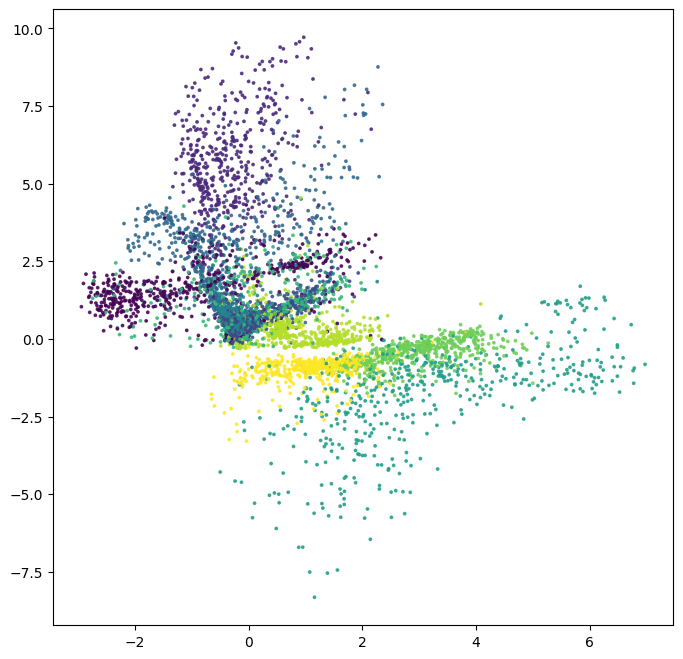

In [7]:
####################################
##### 7. Embed using `Encoder` #####
####################################

num_samples = 5000  # 샘플 수 설정
num_iters = np.ceil(num_samples / BATCH_SIZE).astype(int)  # 필요한 반복 횟수 계산

for i, (test_x, test_y) in enumerate(test_loader):  # 테스트 데이터 로더에서 배치 단위로 데이터 로드
    test_x = test_x.to(DEVICE)  # 입력 데이터를 GPU로 이동
    with torch.no_grad():  # 기울기 계산 비활성화
        embeddings = ae.encoder(test_x)  # 인코더를 사용하여 입력 데이터를 잠재 공간에 임베딩  <--encoder
    if i == 0:  # 첫 번째 배치일 경우
        output_embs = embeddings  # 임베딩 결과 저장
        output_labels = test_y  # 라벨 저장
    else:  # 첫 번째 배치가 아닐 경우
        output_embs = torch.concatenate([output_embs, embeddings])  # 기존 임베딩에 추가
        output_labels = torch.concatenate([output_labels, test_y])  # 기존 라벨에 추가
    if i == num_iters - 1: break  # 필요한 반복 횟수만큼 반복

output_embs = output_embs.detach().cpu().numpy()  # 임베딩 결과를 CPU로 이동하여 NumPy 배열로 변환
output_labels = output_labels.detach().cpu().numpy()  # 라벨을 CPU로 이동하여 NumPy 배열로 변환

plt.figure(figsize=(8, 8))  # 플롯 크기 설정
plt.scatter(output_embs[:, 0],  # 잠재 공간의 첫 번째 차원을 x축으로 설정
            output_embs[:, 1],  # 잠재 공간의 두 번째 차원을 y축으로 설정
            c=output_labels,  # 라벨에 따라 색상 설정
            alpha=0.8,  # 투명도 설정
            s=3)  # 점 크기 설정
plt.show()  # 플롯 출력

### 3.2.8 새로운 이미지 생성하기

잠재 공간에서 샘플링한 벡터를 사용하여 새로운 이미지를 생성합니다.

이 코드는 잠재 공간에서 샘플링한 벡터를 사용하여 새로운 이미지를 생성하고, 이를 시각화합니다. 

잠재 공간에서 샘플링된 좌표를 빨간색 점으로 표시하고, 해당 좌표에서 생성된 이미지를 서브플롯으로 출력합니다.

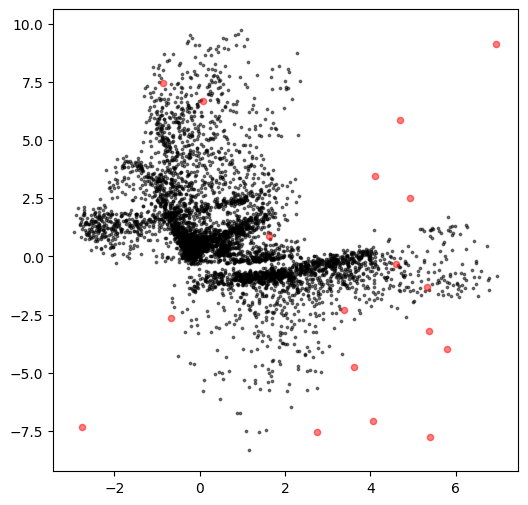

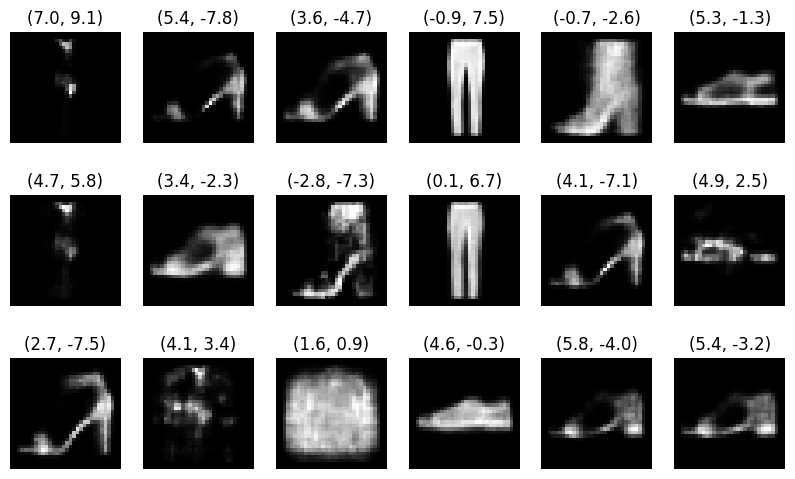

In [8]:
#######################################
##### 8. Generate using `Decoder` #####
#######################################

# Sampling from the embedding spac 잠재 공간에서 샘플링
x_min, x_max = output_embs[:, 0].min(), output_embs[:, 0].max()  # 잠재 공간의 x축 최소값과 최대값 계산
y_min, y_max = output_embs[:, 1].min(), output_embs[:, 1].max()  # 잠재 공간의 y축 최소값과 최대값 계산

xs = np.random.uniform(x_min, x_max, size=(18, 1))  # x축 범위 내에서 균일 분포 샘플링
ys = np.random.uniform(y_min, y_max, size=(18, 1))  # y축 범위 내에서 균일 분포 샘플링
samples = np.hstack([xs, ys])  # 샘플링된 x, y 좌표를 결합

samples_torch = torch.tensor(samples, device=DEVICE, dtype=torch.float32)  # 샘플을 Tensor로 변환하고 GPU로 이동

with torch.no_grad():  # 기울기 계산 비활성화
    output_imgs = ae.generate(samples_torch).detach().cpu().numpy()  # 샘플을 사용하여 이미지를 생성하고 CPU로 이동  <--decoder
output_imgs = output_imgs.transpose((0, 2, 3, 1))  # 이미지의 축을 재정렬

# 잠재 공간에서 샘플링한 점 시각화
plt.figure(figsize=(6, 6))  # 플롯 크기 설정
plt.scatter(output_embs[:, 0],  # 잠재 공간의 첫 번째 차원을 x축으로 설정
            output_embs[:, 1],  # 잠재 공간의 두 번째 차원을 y축으로 설정
            c='black',  # 점 색상 설정
            alpha=0.5,  # 투명도 설정
            s=3)  # 점 크기 설정
plt.scatter(samples[:, 0],  # 샘플링한 x 좌표
            samples[:, 1],  # 샘플링한 y 좌표
            c='red',  # 점 색상 설정
            alpha=0.5,  # 투명도 설정
            s=20)  # 점 크기 설정
plt.show()  # 플롯 출력

# Generate new images from sampled embeddings 샘플링된 임베딩을 사용하여 생성된 이미지 시각화
fig, axes = plt.subplots(nrows=3, ncols=6, figsize=(10, 6))  # 서브플롯 생성
for i in range(output_imgs.shape[0]):  # 생성된 이미지 수만큼 반복
    curr_row = i // 6  # 현재 행 계산
    curr_col = i % 6  # 현재 열 계산
    ax = axes[curr_row, curr_col]  # 현재 서브플롯 선택
    
    ax.set_title(f'({samples[i][0]:.1f}, {samples[i][1]:.1f})')  # 서브플롯 제목 설정
    ax.axis('off')  # 축 비활성화
    ax.imshow(output_imgs[i], cmap='gray')  # 서브플롯에 이미지 표시

plt.show()  # 서브플롯 출력

### * 결과 *

![nn](Image/3.jpg)